In [1]:
import os
import time
import glob
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Config

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
DATA_PATH = os.path.join(data_folder, "trials_training_filtered2.csv")
ANALYSIS_PATH = os.path.join(data_dir, f'{exp}_modeling')
os.makedirs(ANALYSIS_PATH, exist_ok=True)
FIGURES_PATH = os.path.join(ANALYSIS_PATH, "figures")
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(f'{ANALYSIS_PATH}/models', exist_ok=True)
os.makedirs(f'{ANALYSIS_PATH}/data', exist_ok=True)
os.makedirs(f'{ANALYSIS_PATH}/results', exist_ok=True)

custom_palette = {'s': "#ffb400", 'l': "#9080ff"}

In [3]:
TARGET = "time_waited"

GROUP_FEATURES = ['group']
SESSION_FEATURES = ['session', 'session_trial_num', 'block_trial_num', 'block_num', 'mouse']
BACKGROUND_FEATURES = [
       'bg_drawn', 'bg_length', 'bg_repeats', 'num_bg_licks', 'previous_trial_bg_repeats', 
       'bg_repeats_rolling_mean_5', 'bg_repeats_rolling_mean_10'
       ]
WAIT_HISTORY_FEATURES = ['previous_trial_time_waited', 'time_waited_rolling_mean_5', 'time_waited_rolling_mean_10', 'previous_trial_miss_trial']
REWARD_FEATURES = [
       'previous_trial_reward', 'rewarded_streak', 'unrewarded_streak', 'time_since_last_reward_in_block',
       'cumulative_reward_in_block', 'cumulative_reward', 'reward_rate_since_block_start',
       'reward_rate_past_1min_in_block', 'reward_rate_past_5min_in_block', 'reward_rate_past_10min_in_block'
       ]

FEATURES_ALL = GROUP_FEATURES + SESSION_FEATURES + REWARD_FEATURES + BACKGROUND_FEATURES + WAIT_HISTORY_FEATURES
FEATURES_NO_SESSION = GROUP_FEATURES + REWARD_FEATURES + BACKGROUND_FEATURES + WAIT_HISTORY_FEATURES
FEATURES_NO_BACKGROUND = GROUP_FEATURES + SESSION_FEATURES + REWARD_FEATURES + WAIT_HISTORY_FEATURES
FEATURES_NO_WAIT = GROUP_FEATURES + SESSION_FEATURES + REWARD_FEATURES + BACKGROUND_FEATURES
FEATURES_ONLY_WAIT = GROUP_FEATURES + WAIT_HISTORY_FEATURES
FEATURES_NO_REWARD = GROUP_FEATURES + SESSION_FEATURES + BACKGROUND_FEATURES + WAIT_HISTORY_FEATURES
FEATURES_ONLY_REWARD = GROUP_FEATURES + REWARD_FEATURES

In [4]:
FEATURES = FEATURES_ALL

FEATURES_SETS_DICT = {
    'all': FEATURES_ALL,
    'no_session': FEATURES_NO_SESSION,
    'no_background': FEATURES_NO_BACKGROUND,
    'no_wait': FEATURES_NO_WAIT,
    'only_wait': FEATURES_ONLY_WAIT,
    'no_reward': FEATURES_NO_REWARD,
    'only_reward': FEATURES_ONLY_REWARD
}

CATEGORICAL_ALL = ["group", "mouse", "previous_trial_reward", 'previous_trial_miss_trial']

RNG = 43 # Random state

In [5]:
# stage_files = {
#     'all': "trials_training_filtered2.csv",
#     'early': "trials_training_filtered2_early.csv",
#     'middle': "trials_training_filtered2_middle.csv",
#     'late': "trials_training_filtered2_late.csv"
# }

stage_files = {
    'all': "trials_training_filtered2.csv",
}

In [6]:
def process_data(df):
    # transform target and clean data
    # df['time_waited_transformed'] = np.log1p(df['time_waited'])
    df = df.loc[(df['miss_trial'] == False) & (~df[TARGET].isna())].copy()
    df["time_since_last_reward_in_block"] = df["time_since_last_reward_in_block"].fillna(2000)

    # preserve original columns
    df['session_original'] = df['session']
    df['session_trial_num_original'] = df['session_trial_num']
    df['mouse_original'] = df['mouse']
    df['group_original'] = df['group']
    df['time_waited_original'] = df['time_waited']
    return df

In [7]:
# Load and preprocess data
df = pd.read_csv(DATA_PATH)
df_og = process_data(df)

In [8]:
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return dict(r2=r2, mae=mae, rmse=rmse)

### baseline model using only grup

One model at a time

In [ ]:
FEATURES_baseline = GROUP_FEATURES
CATEGORICAL_baseline = GROUP_FEATURES

In [ ]:
df_encoded = pd.get_dummies(df_og, columns=CATEGORICAL_baseline)
encoded_columns_baseline = [c for c in df_encoded.columns if c not in df_og.columns]

X = df_encoded
y = df_og[TARGET]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)

X_train_baseline, X_test_baseline = X_train_raw[encoded_columns_baseline], X_test_raw[encoded_columns_baseline]

model = LinearRegression().fit(X_train_baseline, y_train)
y_pred = model.predict(X_test_baseline)

print(f"Mean predicted value for group_l: {y_pred[X_test_baseline['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred[X_test_baseline['group_s'] == 1].mean():.3f}")
compute_metrics(y_test, y_pred)


In [ ]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=50,
    n_jobs=-1,
    random_state=RNG
).fit(X_train_baseline, y_train)
y_pred = model.predict(X_test_baseline)

print(f"Mean predicted value for group_l: {y_pred[X_test_baseline['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred[X_test_baseline['group_s'] == 1].mean():.3f}")
compute_metrics(y_test, y_pred)


Looping

In [ ]:
def train_baseline_models(df_og, TARGET, RNG):
    metrics = {}
    FEATURES_baseline = GROUP_FEATURES
    CATEGORICAL_baseline = GROUP_FEATURES
    df_encoded = pd.get_dummies(df_og, columns=CATEGORICAL_baseline)
    encoded_columns_baseline = [c for c in df_encoded.columns if c not in df_og.columns]
    
    X = df_encoded
    y = df_og[TARGET]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RNG
    )

    X_train_baseline, X_test_baseline = X_train_raw[encoded_columns_baseline], X_test_raw[encoded_columns_baseline]
    linear = LinearRegression().fit(X_train_baseline, y_train)
    y_pred_linear = linear.predict(X_test_baseline)
    linear_metrics = compute_metrics(y_test, y_pred_linear)
    metrics['linear_r2'] = linear_metrics['r2']
    metrics['linear_mae'] = linear_metrics['mae']
    metrics['linear_rmse'] = linear_metrics['rmse']

    rf = RandomForestRegressor(n_estimators=100, max_depth=50, n_jobs=-1, random_state=RNG).fit(X_train_baseline, y_train)
    y_pred_rf = rf.predict(X_test_baseline)
    rf_metrics = compute_metrics(y_test, y_pred_rf)
    metrics['rf_r2'] = rf_metrics['r2']
    metrics['rf_mae'] = rf_metrics['mae']
    metrics['rf_rmse'] = rf_metrics['rmse']
    return metrics

In [ ]:
baseline_metrics = {}
for file_name, stage in zip(file_names, stages):
    df= pd.read_csv(os.path.join(data_folder, file_name))
    df_og = process_data(df)
    metrics = train_baseline_models(df_og, TARGET, RNG)
    baseline_metrics[stage] = metrics
base_metrics_df = pd.DataFrame(baseline_metrics)

In [ ]:
base_metrics_df

In [ ]:
# Simple grouped bar plot of R² scores for each model and stage
stage_order = list(base_metrics_df.columns)
x = np.arange(len(stage_order))
bar_width = 0.35

linear_r2 = base_metrics_df.loc['linear_r2', stage_order]
rf_r2 = base_metrics_df.loc['rf_r2', stage_order]

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - bar_width/2, linear_r2, bar_width, label='Linear Regression', color='steelblue', alpha=0.7)
rects2 = ax.bar(x + bar_width/2, rf_r2, bar_width, label='Random Forest', color='forestgreen', alpha=0.7)

ax.set_xlabel('Trial Stage in Session')
ax.set_ylabel('R² Score')
ax.set_title('R² by Stage and Model')
ax.set_xticks(x)
ax.set_xticklabels(stage_order)
ax.set_ylim(0, max(linear_r2.max(), rf_r2.max()) * 1.1)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f'{ANALYSIS_PATH}/baseline_model_r2_comparison.png', dpi=300, bbox_inches='tight')

### Models using to use all features

In [ ]:
feature_set = FEATURES_ALL
target_single = 'time_waited_transformed'

In [ ]:
df = pd.read_csv(os.path.join(data_folder, "trials_training_filtered2.csv"))
df_og = process_data(df)
df_og['time_waited_transformed'] = np.log1p(df_og['time_waited'])

CATEGORICAL = [c for c in CATEGORICAL_ALL if c in feature_set]
NUMERIC = [col for col in feature_set if col not in CATEGORICAL]

df_encoded = pd.get_dummies(df_og, columns=CATEGORICAL)
numeric_cols = [col for col in NUMERIC if col in df_encoded.columns]
df_encoded[numeric_cols] = StandardScaler().fit_transform(df_encoded[numeric_cols])

dummy_cols = [c for c in df_encoded.columns if c not in df_og.columns]
encoded_columns = sorted(dummy_cols + numeric_cols)

X = df_encoded
y = df_og[target_single]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

# Only use the encoded columns that were created during training
X_train, X_test = X_train_raw[encoded_columns], X_test_raw[encoded_columns]

# Fit model and predict
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=50,
    n_jobs=-1,
    random_state=RNG
)
model_rf.fit(X_train, y_train)

# Use model_rf instead of model for prediction
y_pred = model_rf.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

print(f"Mean predicted value for group_l: {y_pred[X_test['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred[X_test['group_s'] == 1].mean():.3f}")
print(metrics)

In [ ]:
importances = model_rf.feature_importances_
feat_names = X_train.columns
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(6,4))
plt.barh(range(len(fi)), fi.values)
plt.yticks(range(len(fi)), fi.index)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

linear regression

In [ ]:
df = pd.read_csv(os.path.join(data_folder, "trials_training_filtered2.csv"))
df_og = process_data(df)

CATEGORICAL = [c for c in CATEGORICAL_ALL if c in feature_set]
NUMERIC = [col for col in feature_set if col not in CATEGORICAL]

df_encoded = pd.get_dummies(df_og, columns=CATEGORICAL)
numeric_cols = [col for col in NUMERIC if col in df_encoded.columns]
df_encoded[numeric_cols] = StandardScaler().fit_transform(df_encoded[numeric_cols])

dummy_cols = [c for c in df_encoded.columns if c not in df_og.columns]
encoded_columns = sorted(dummy_cols + numeric_cols)

X = df_encoded
y = df_og[TARGET]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

# Only use the encoded columns that were created during training
X_train, X_test = X_train_raw[encoded_columns], X_test_raw[encoded_columns]

# Fit model and predict
model_linear = LinearRegression().fit(X_train, y_train)

# Use model_rf instead of model for prediction
y_pred = model_linear.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

print(f"Mean predicted value for group_l: {y_pred[X_test['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred[X_test['group_s'] == 1].mean():.3f}")
print(metrics)

cursor helps me loop

In [ ]:
overwrite = False
for stage, file_name in stage_files.items():
    print(f"\n=== Processing Stage: {stage} ===")
    df = pd.read_csv(os.path.join(data_folder, file_name))
    df_og = process_data(df)
    for feature_set_name, feature_set in FEATURES_SETS_DICT.items():
        print(f"  Feature Set: {feature_set_name}")
        model_filenames = {
            'linear': f'{ANALYSIS_PATH}/models/linear_model_{stage}_{feature_set_name}.pkl',
            'rf': f'{ANALYSIS_PATH}/models/rf_model_{stage}_{feature_set_name}.pkl'
        }
        # If both model files exist, skip this feature set
        if all(os.path.exists(path) for path in model_filenames.values()):
            print("    Both models already exist. Skipping.")
            continue

        CATEGORICAL = [c for c in CATEGORICAL_ALL if c in feature_set]
        NUMERIC = [col for col in feature_set if col not in CATEGORICAL]
        df_encoded = pd.get_dummies(df_og, columns=CATEGORICAL)
        numeric_cols = [col for col in NUMERIC if col in df_encoded.columns]
        if numeric_cols:
            df_encoded[numeric_cols] = StandardScaler().fit_transform(df_encoded[numeric_cols])
        dummy_cols = [c for c in df_encoded.columns if c not in df_og.columns]
        encoded_columns = sorted(dummy_cols + numeric_cols)
        X = df_encoded
        y = df_og[TARGET]

        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)
        X_train, X_test = X_train_raw[encoded_columns], X_test_raw[encoded_columns]

        models = {
            'linear': LinearRegression(),
            'rf': RandomForestRegressor(n_estimators=100, max_depth=50, n_jobs=-1, random_state=RNG)
        }
        for model_name, model in models.items():
            model_filename = f'{ANALYSIS_PATH}/models/{model_name}_model_{stage}_{feature_set_name}.pkl'
            data_filename = f'{ANALYSIS_PATH}/data/{model_name}_data_{stage}_{feature_set_name}.pkl'
            if os.path.exists(model_filename) and os.path.exists(data_filename) and not overwrite:
                print(f"    {model_name} model and data already exist. Skipping.")
                continue
            try:
                t0 = time.time()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                metrics = compute_metrics(y_test, y_pred)
                r2 = metrics['r2']
                mae = metrics['mae']
                rmse = metrics['rmse']
                joblib.dump(model, model_filename)
                joblib.dump({
                    'X_train_raw': X_train_raw,
                    'X_test_raw': X_test_raw,
                    'y_train': y_train,
                    'y_test': y_test,
                    'X_train': X_train,
                    'X_test': X_test,
                    'predictions': y_pred,
                    'feature_names': encoded_columns,
                    'stage': stage,
                    'feature_set': feature_set_name,
                    'model_type': model_name
                }, data_filename)
                print(f"    {model_name}: R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f} (fit in {time.time()-t0:.1f}s)")
            except KeyboardInterrupt:
                print("    Interrupted by user.")
                raise
            except Exception as e:
                print(f"    Error fitting {model_name}: {e}")
                continue

print("\n=== Analysis Complete ===")
print(f"Models saved to: {ANALYSIS_PATH}/models/")
print(f"Data saved to: {ANALYSIS_PATH}/data/")

In [ ]:
data_files = glob.glob(f"{ANALYSIS_PATH}/data/*_data_*.pkl")
results_records = []

for data_file in data_files:
    try:
        data = joblib.load(data_file)
        # Try to infer the corresponding model file path
        model_type = data.get('model_type', None)
        stage = data.get('stage', None)
        feature_set = data.get('feature_set', None)
        model_file_path = f"{ANALYSIS_PATH}/models/{model_type}_model_{stage}_{feature_set}.pkl"
        # Compute metrics if not present
        y_test = data.get('y_test', None)
        predictions = data.get('predictions', None)
        if y_test is not None and predictions is not None:
            metrics = compute_metrics(y_test, predictions)
            r2 = metrics['r2']
            mae = metrics['mae']
            rmse = metrics['rmse']
        else:
            r2 = mae = rmse = None
        results_records.append({
            'stage': stage,
            'feature_set': feature_set,
            'model_type': model_type,
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'n_train_samples': len(data.get('X_train', [])),
            'n_test_samples': len(data.get('X_test', [])),
            'feature_count': len(data.get('feature_names', [])),
            'model_file_path': model_file_path,
            'data_file_path': data_file
        })
    except Exception as e:
        print(f"Error loading {data_file}: {e}")

results_df = pd.DataFrame(results_records)
results_csv_path = f'{ANALYSIS_PATH}/results/model_comparison_results.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"\nResults saved to: {results_csv_path}")

print("\nResults Summary:")
if not results_df.empty:
    print(results_df.groupby(['stage', 'model_type'])['r2'].mean().unstack())
else:
    print("No results to summarize.")

In [3]:
results = pd.read_csv(f'{ANALYSIS_PATH}/results/model_comparison_results.csv')

In [4]:
results

,stage,feature_set,model_type,r2,mae,rmse,n_train_samples,n_test_samples,feature_count,model_file_path,data_file_path
0,late,no_session,linear,0.369434,3.045567,5.896402,110400,27600,25,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
1,middle,no_wait,linear,0.178866,1.899126,3.637675,227989,56998,53,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
2,late,no_background,linear,0.374979,3.073332,5.870421,110400,27600,51,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
3,early,no_reward,rf,0.197795,1.221407,2.504471,114892,28724,48,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
4,all,no_wait,linear,0.170866,2.254208,4.500163,453282,113321,53,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
5,late,no_reward,rf,0.364804,3.073697,5.918009,110400,27600,47,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
6,all,only_wait,linear,0.329019,1.944138,4.048287,453282,113321,8,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
7,early,no_wait,rf,0.177582,1.226148,2.535827,114892,28724,53,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
8,late,no_session,rf,0.387416,2.983620,5.811721,110400,27600,25,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...
9,all,no_session,rf,0.382816,1.832268,3.882605,453282,113321,26,/Users/rebekahzhang/data/behavior_data/exp2_mo...,/Users/rebekahzhang/data/behavior_data/exp2_mo...


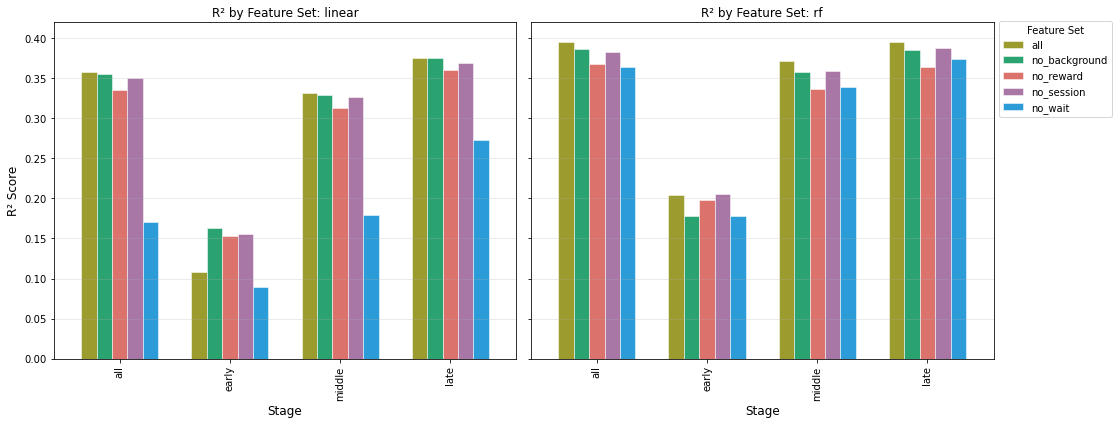

In [5]:
stage_order = ['all', 'early', 'middle', 'late']
model_order = ['linear', 'rf']
feature_set_order = ['all', 'no_session', 'no_background', 'no_wait', 'no_reward']

# Define a beautiful color palette
colors = ['#9B9C2D', '#2AA371', '#DB726B', '#A977A6', '#2B9CD7']  # Professional, distinct colors

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for i, model in enumerate(model_order):
    df = results[
        (results['model_type'] == model) &
        (results['stage'].isin(stage_order)) &
        (results['feature_set'].isin(feature_set_order))
    ]
    pivot = df.pivot(index='stage', columns='feature_set', values='r2').reindex(stage_order)
    ax = axes[i]
    
    # Plot with custom colors
    pivot.plot(kind='bar', ax=ax, width=0.7, legend=False, color=colors)
    
    ax.set_title(f'R² by Feature Set: {model}')
    if i == 0:
        ax.set_ylabel('R² Score', fontsize=12)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Stage', fontsize=12)
    ax.set_ylim(0, 0.42)
    ax.grid(axis='y', alpha=0.3)
    
    # Make the bars look nicer
    for patch in ax.patches:
        patch.set_edgecolor('white')
        patch.set_linewidth(0.5)

# Add legend for feature sets
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Feature Set', loc='center left', bbox_to_anchor=(0.99, 0.83))
plt.tight_layout()
plt.show()

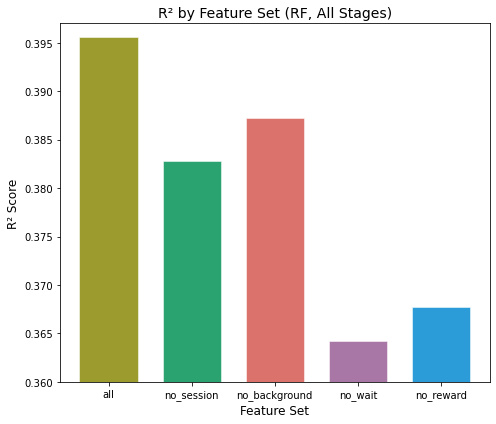

In [6]:
results_all_stages = results.loc[(results['stage'] == 'all') & (results['model_type'] == 'rf')]

feature_set_order = ['all', 'no_session', 'no_background', 'no_wait', 'no_reward']
colors = ['#9B9C2D', '#2AA371', '#DB726B', '#A977A6', '#2B9CD7']
results_all_stages = results_all_stages.set_index('feature_set').reindex(feature_set_order)

plt.figure(figsize=(7, 6))
bars = plt.bar(results_all_stages.index, results_all_stages['r2'], color=colors, width=0.7, edgecolor='white', linewidth=0.5)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Feature Set', fontsize=12)
plt.title('R² by Feature Set (RF, All Stages)', fontsize=14)
plt.ylim(0.36, 0.397)
plt.tight_layout()
plt.savefig(f'{ANALYSIS_PATH}/figures/rf_r2_by_feature_set_all_stages.png', dpi=300, bbox_inches='tight')

### random forest plots

In [7]:
# predictions = model_rf.predict(X_test_all_features)
# X_test_raw["predictions"] = predictions
# X_test_raw["time_waited_transformed"] = np.log1p(X_test_raw["time_waited"])
# # X_test_raw["predictions_transformed"] = np.expm1(X_test_raw["predictions"] + np.var(predictions)/2)

# df_to_plot = X_test_raw

In [8]:
def plot_rf_predictions_vs_actual(df, palette, figure_title=None, save_name=None):
    """
    Plot RF predictions vs actual data by session and group.
    """
    stats = df.groupby(['session_original', 'group_original'], as_index=False).agg(
        mean_tw=('time_waited', 'mean'),
        se_tw=('time_waited', lambda x: x.std() / np.sqrt(len(x))),
        mean_pred=('predictions', 'mean')
    )

    plt.figure(figsize=(12, 4))
    for group in stats['group_original'].unique():
        g = stats[stats['group_original'] == group]
        plt.plot(g['session_original'], g['mean_pred'], '--', lw=3, color=palette[group], label=f'{group.upper()} (Prediction)')
        plt.plot(g['session_original'], g['mean_tw'], 'o-', ms=6, lw=2, color=palette[group], label=f'{group.upper()} (Data)')
        plt.fill_between(g['session_original'], g['mean_tw'] - g['se_tw'], g['mean_tw'] + g['se_tw'], alpha=0.3, color=palette[group])

    plt.title(f'RF Predictions vs Actual (Test Set Only) ({figure_title})', fontsize=14)
    plt.xlabel('Session Number')
    plt.ylabel('Time Waited (s)')
    plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
    plt.xlim(df['session_original'].min(), df['session_original'].max())
    plt.tight_layout()
    if save_name:
        plt.savefig(f'{FIGURES_PATH}/{save_name}', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [9]:
def load_model_results(stage, feature_set, model_type='rf'):
    """Load saved model data and return test set with predictions and group info."""
    data_file = f'{ANALYSIS_PATH}/data/{model_type}_data_{stage}_{feature_set}.pkl'
    saved_data = joblib.load(data_file)
    df = saved_data['X_test_raw'].copy()
    df['predictions'] = saved_data['predictions']
    df = saved_data['X_test_raw'].copy()
    df['predictions'] = saved_data['predictions']
    return df

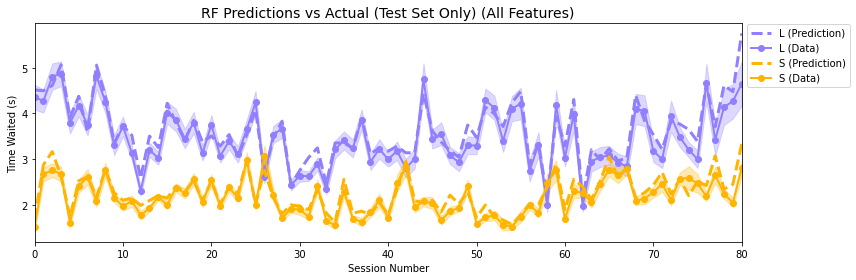

In [10]:
df_all_all = load_model_results('all', 'all', 'rf')
plot_rf_predictions_vs_actual(df_all_all, custom_palette, figure_title='All Features', save_name='all_sessions_predictions_vs_actual_all_all.png')


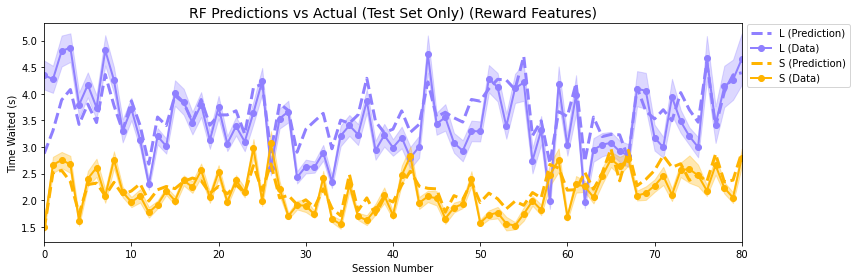

In [11]:
df_all_reward_only = load_model_results('all', 'only_reward', 'rf')
plot_rf_predictions_vs_actual(df_all_reward_only, custom_palette, figure_title='Reward Features', save_name='all_sessions_predictions_vs_actual_all_reward_only.png')

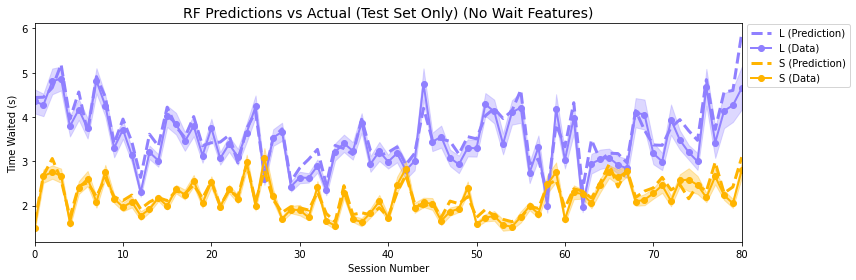

In [12]:
df_all_no_wait = load_model_results('all', 'no_wait', 'rf')
plot_rf_predictions_vs_actual(df_all_no_wait, custom_palette, figure_title='No Wait Features', save_name='all_sessions_predictions_vs_actual_all_no_wait.png')

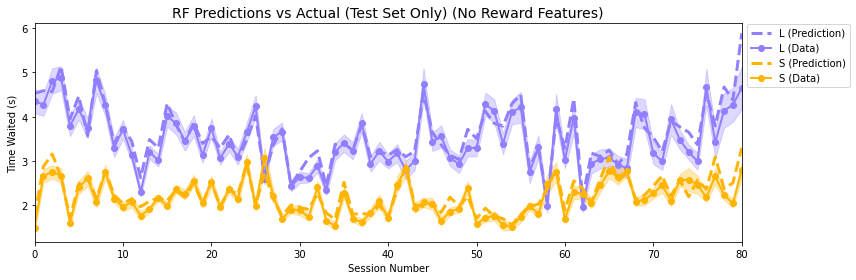

In [13]:
df_all_no_reward = load_model_results('all', 'no_reward', 'rf')
plot_rf_predictions_vs_actual(df_all_no_reward, custom_palette, figure_title='No Reward Features', save_name='all_sessions_predictions_vs_actual_all_no_reward.png')

In [14]:
def plot_session_fit(df, session_info, fig_size=(12, 5), save_name=None):
    # Filter for the session
    session_data = df[df['dir'] == session_info['dir']].sort_values('session_trial_num_original')
    group = session_info['group_original']
    trial_nums = session_data['session_trial_num_original']
    actual = session_data[TARGET]
    pred = session_data['predictions']

    fig, axes = plt.subplots(1, 2, figsize=fig_size)

    # Actual vs Predicted
    axes[0].plot(trial_nums, actual, 'o', color=custom_palette[group], label='Actual', markersize=4, alpha=0.7)
    axes[0].plot(trial_nums, pred, 's', color='#7BB662', label='Predicted', markersize=3, alpha=0.7)
    axes[0].set(xlabel='Trial Number', ylabel='Time Waited (s)', title='Actual vs Predicted')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Residuals
    residuals = actual - pred
    axes[1].scatter(trial_nums, residuals, color='#FF6B5A', alpha=0.7, s=20)
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.8)
    axes[1].set(xlabel='Trial Number', ylabel='Residuals', title='Prediction Residuals')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'{FIGURES_PATH}/{save_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [15]:
df_to_plot = df_all_all

In [16]:
r2_by_dir = df_to_plot.groupby('dir').apply(
    lambda g: pd.Series({
        'r2': r2_score(g['time_waited_original'], g['predictions']),
        'n_points': len(g)
    })
).reset_index().sort_values('r2', ascending=False)
r2_by_dir_filtered = r2_by_dir[r2_by_dir['n_points'] > 60]

# Plot top 30 sessions based on r2_by_dir_filtered
top_sessions = r2_by_dir_filtered.head(30)
for _, row in top_sessions.iterrows():
    session_info = df_to_plot[df_to_plot['dir'] == row['dir']].iloc[0]
    plot_session_fit(df_to_plot, session_info, save_name=f"{row['dir']}_fit.png")

NameError: name 'TARGET' is not defined

In [ ]:
def plot_feature_importances(importances, feature_names, save_name=None):
    fi = pd.Series(importances, index=feature_names).nlargest(15)
    plt.figure(figsize=(6,4))
    plt.barh(fi.index, fi.values)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importances\nStage: {row['stage']}, Features: {row['feature_set']}")
    plt.gca().invert_yaxis()
    if save_name:
        plt.savefig(f'{FIGURES_PATH}/{save_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
results = pd.read_csv(f'{ANALYSIS_PATH}/results/model_comparison_results.csv')

for _, row in results[results['model_type'] == 'rf'].iterrows():
    feature_names = joblib.load(row['data_file_path'])['feature_names']
    importances = joblib.load(row['model_file_path']).feature_importances_
    fi = pd.Series(importances, index=feature_names).nlargest(15)
    save_name = f"feature_importances_{row['stage']}_{row['feature_set']}.png"
    plot_feature_importances(importances, feature_names, save_name)

In [ ]:
# importances = model_rf.feature_importances_
# feat_names = X_train_all_features.columns
# fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:15]

# plt.figure(figsize=(6,4))
# plt.barh(range(len(fi)), fi.values)
# plt.yticks(range(len(fi)), fi.index)
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("Feature Importances")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [ ]:
model_all_linear = load_model_results('all', 'all', 'linear')

In [ ]:
# Load linear model and feature names
model_linear = joblib.load(f'{ANALYSIS_PATH}/models/linear_model_all_all.pkl')
feature_names = joblib.load(f'{ANALYSIS_PATH}/data/linear_data_all_all.pkl')['feature_names']

# Create DataFrame of coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': model_linear.coef_})

# Remove mouse_ features, then sort and reindex by absolute coefficient value (descending)
coef_df_no_mouse = coef_df[~coef_df['feature'].str.startswith('mouse_')]
coef_df_no_mouse = coef_df_no_mouse.reindex(coef_df_no_mouse['coefficient'].abs().sort_values(ascending=False).index)

print(f"Intercept: {model_linear.intercept_:.4f}\n")
print("Top 20 features by absolute coefficient value:")
print(coef_df_no_mouse.head(20))

# Plot top 20 coefficients (simplified)
top_coefs = coef_df_no_mouse.head(20)
plt.barh(top_coefs['feature'], top_coefs['coefficient'], color=['#2AA371' if x > 0 else '#DB726B' for x in top_coefs['coefficient']])
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFull coefficient table:")
print(coef_df_no_mouse)

In [ ]:
trials = pd.read_csv(os.path.join(data_folder, "trials_training_filtered2.csv"))
trials_s = trials[trials['group']=='s']
trials_l = trials[trials['group']=='l']

In [ ]:
trials.keys()

In [ ]:
# Downsample by taking every 20th point (adjust as needed for clarity)
downsample_factor = 20
downsampled = trials_s.iloc[::downsample_factor, :]

plt.figure(figsize=(8, 5))
plt.scatter(
    downsampled['session_trial_num'],
    downsampled['time_waited_rolling_mean_10'],
    alpha=0.7, s=1
)
# plt.xlim(0, 400)
plt.xlabel('Session Trial Number')
plt.ylabel('Time Waited Rolling Mean (10)')
plt.title('Session Trial Number vs. Time Waited Rolling Mean (10) (Downsampled)')
plt.tight_layout()
plt.show()
